<h1><center> Lab Session n°2 : RL for stochastic control problems  </center></h1>



<h2> 📌 Objectives: </h2>

In the **first part** of the **lab session**, you will solve one stochastic contol problem in finance : A simple market impact model.  You will explore and implement the algorithms introduced in the lecture using Python and its scientific libraries.

The **second part** of the **lab session** will be devoted to mathematical questions on solving linear quadratic control problems in continuous time.


<h2>📚 Goal of the Lab: </h2>

By the end of this lab, you will be able to:

- Undertand and implement some **reinforcement algorithms** to solve stochastic control problems arising in finance.

- Derive explicitly the **optimal policy** and **value function** arising in the **Linear quadratic** control problems in continuous time.


<h2> 🗂️ Lab Structure and assignments: </h2>

This notebook is organized into the following sections:




**1. [On the Market impact problem](#MarketImpact-Applications)**

&nbsp;&nbsp;&nbsp;&nbsp;1.1 [Problem formulation](#MarketImpact-problemformulation)

&nbsp;&nbsp;&nbsp;&nbsp;1.2 [Q-learning and Sarsa algorithms](#MarketImpact-Q-function)


**2. [Mathematical questions](#Mathematical-Questions)**

&nbsp;&nbsp;&nbsp;&nbsp; [Linear quadratic case in continuous time](#Mathematical-Questions-LQ-case)




**3. [References](#references)**  


This lab will include **mathematics** and/or **coding** questions indicated by ❓. **Your answers** indicated by ✏️ will count for your final grade of the course, with a weight to be determined later with respect to the project. Note that the project will have a significant higher weight in the final grade.


**Mathematics Questions**

- You can answer directly in the **Jupyter notebook** using LaTeX (compatible with Markdown).


**Coding Questions**

-  Complete the corresponding code sections **directly in the notebook**.
-  **Code readability**, **quality**, and **clarity of comments** will be taken into account in the **grading**.


If you choose this lab, you will have to send your work by e-mail at [samy.mekkaoui@polytechnique.edu](mailto:samy.mekkaoui@polytechnique.edu). The submission deadline will be announced later during the course.



<h2>ℹ️ Other informations: </h2>




- **Key References**: If you want to go deeper on the use of RL methods for solving stochastic control problems in finance, you can look at the section [References](#references). <br> <br>



- **Contact**: If you find any mistakes in this notebook, or have any other feedback or questions, please feel free to e-mail me at [samy.mekkaoui@polytechnique.edu](mailto:samy.mekkaoui@polytechnique.edu).


In [8]:
# Import Packages

import numpy as np
import matplotlib
import pandas as pd

from scipy.stats import norm

import matplotlib.pyplot as plt 

from tqdm import tqdm 

import time

<a id=MarketImpact-Applications></a>

<h1> <center> 1: On the Market Impact Problem  </center> </h1>



<a  id=MarketImpact-problemformulation></a>

<h2> 1.1 Problem formulation : </h2>

Assume that the broker has to sell $N$ blocks of shares with $n$ shares in each block.   The state variables at time $t$ are given by the stock price $S_t$ and the number of blocks of shares remaining to be sold $X_t$. The initial values are given by $S_0$ and $X_0= N-1$. The time horizon is given by $T$ and the time step is denoted by $\Delta t$. We denote by $\sigma$ the volatility of the stock and by $\epsilon_t \sim \mathcal{N}(0, \Delta t)$ a standard normal random variable.

In each step, the agent has four possible actions $a_t= a^{(i)}$ where $ i \in \lbrace 0, 1, 2 ,3 \rbrace$ and $a^{(i)}=i$ measure the number of blocks of shares sold at time $t$. The updated equation for the stock number of blocks is then given by

$$
\begin{align}
X_{t+1} = (X_t-a_t)_{+}
\end{align}
$$
The trades influence the stock price dynamics through a linear market impact as

$$
\begin{align}
S_{t+1} = S_t e^{(1- \nu)a_t)} + \sigma S_t \epsilon_t,
\end{align}
$$
where $\nu$ represents a market impact parameter. In order to have a finite MDP, we map $S$ into $M$ values between $S_{min}$ and $S_{max}$. The state space of the problem is then given by the product space $\mathcal{X} \times \mathcal{S}$ with dimension $M \times N$. When adding the time, the dimension goes to $M \times N \times T$.

The reward function is given by

$$
\begin{align}
f_t= n a_t S_t - \lambda n X_{t+1}^2  \text{ Var }[ S_{t+1} | \mathcal{F}_t].
\end{align}
$$
where $\lambda$ is a risk aversion parameter. 

- $n a_t S_t$ represents the revenue generated by selling $a_t$ blocks of shares at price $S_t$.
- $ \text{ Var }[ S_{t+1} X_{t+1} | \mathcal{F}_t ]$ represents the variance of the portfolio value at time $t+1$ given information at $t$.

We can represent a time-depedent action-state function $Q_t(x,a)$ with four possible action into a tensor of dimension $N \times M \times T \times 4$.




The following part is just for having a suitable discretization of the price process into a finite time-grid. It is not relevant for the understanding of the problem. 




In [10]:
S0 = 100      # initial stock price
K = 100       # stike
r = 0.05      # risk-free rate
sigma = 0.15  # volatility
mu = 0.05     # drift
M = 1         # maturity

T = 12        # number of time steps
N_MC = 1000   # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

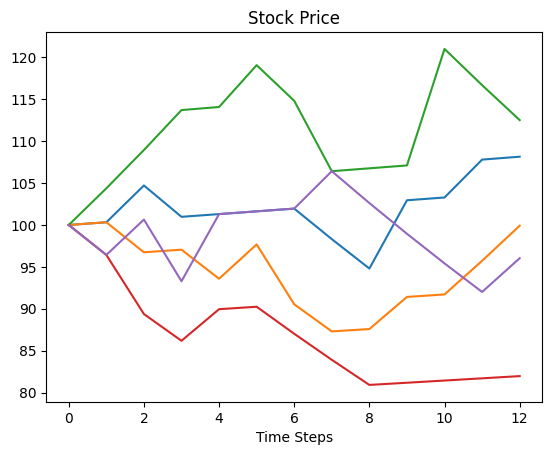

In [13]:
N = 25 # number of discrete states
I = (2 + np.log(np.log(N))) * sigma * np.sqrt(T * delta_t)
p = np.log(S0) + (2 * np.arange(1, N+1) - N - 1) / (N - 1) * I
p = pd.DataFrame(p, index=range(1, N+1))
c = (p.loc[2:,:] + p.shift(1).loc[2:,:]) / 2
c.loc[1,:] = float('-inf')
c.loc[N+1,:] = float('inf')
c = c.sort_index(axis=0)

transition_probability = pd.DataFrame([], index=range(1, N+1), columns=range(1, N+1))
for i in range(1, N+1):
    for j in range(1, N+1):
        a = (c.loc[j+1,0] - p.loc[i,0] - (mu - 0.5*sigma**2)*delta_t)/(sigma*np.sqrt(delta_t))
        b = (c.loc[j,0] - p.loc[i,0] - (mu - 0.5*sigma**2)*delta_t)/(sigma*np.sqrt(delta_t))
        transition_probability.loc[i,j] = norm.cdf(a) - norm.cdf(b)

starttime = time.time()

# state variable
X = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
X.loc[:,0] = np.log(S0)

# position of each state variable on the grid
point = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
point.loc[:,0] = (N + 1) / 2

for k in range(1, N_MC+1):
    x = (N + 1) / 2
    for t in range(1, T+1):
        next_x = np.random.choice(np.arange(1,N+1),replace=True,p=transition_probability.loc[x,:])
        x = next_x
        point.loc[k,t] = x
        X.loc[k,t] = p.loc[x,0]

# stock price
S = X.apply(lambda x: np.exp((x + (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t).astype('float')), axis=1)
delta_S = S.loc[:, 1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# plot 5 paths
plt.plot(S.T.iloc[:,[100,200,300,400,500]])
plt.xlabel('Time Steps')
plt.title('Stock Price')
plt.show()


<h2> The market impact problem : </h2>

In the following, we assume $N=10$, $M=12$ and $T=10$. Therefore, the $Q$-function can be stored into a four-rank tensor of dimension $10 \times 12 \times 10 \times 4$.
  

In [ ]:
BLOCK_SIZE = 1000
NUM_BLOCKS = 10
NUM_S      = 12  #number of discrete values of S
NUM_TIME_STEPS = 10
dt         = 1 # time step
sigma      = 0.1 # volatility of the stock
nu         = 1 # market impact parameter
S0         = 1 # initial stock price
lmbda      = 0.01 # risk aversion parameter

In [ ]:
epsilon = 0.1# Probability for exploration for the epsilon-greedy policy
eta = 0.5# Step size



In the list below, we define 

- The potential actions values, i.e., the number of stocks to sell in the current time and state.
- The state vector for the initial state : [number of blocks of shares, stock price, time]

In [ ]:
ACTIONS = [0, 1, 2, 3]
START = [NUM_BLOCKS - 1, S0, 0]




 ❓ **Question 1.1**: Fill in the function **transition** below the next state and reward obtained from taking action $a$ in state $s$ at time $t$.

In [ ]:
def transition(
    state,   # list: [inventory, price_state, time]
    action,  # int: number of blocks sold
):
    """
    One-step transition for an optimal execution MDP.

    Parameters
    ----------
    state : list of length 3
        state[0] : inventory (number of blocks)
        state[1] : price state (discretized)
        state[2] : time

    action : int
        Number of blocks sold at the current time step

    Returns
    -------
    (next_state, reward) :  State at the next time step and immediate reward
    """

    X = state[0]   # inventory
    S = state[1]   # discretized price state
    t = state[2]   # time

     # You can't sell more stock than you have
    if action > X: 
        action = X

    X_next = ### 

    t_next = t + dt
 
    S_next = (
        S * np.exp(1 - nu * action)
        + sigma * S * np.sqrt(dt) * np.random.randn()
    )
    S_next = int(np.clip(np.ceil(S_next), 0, NUM_S - 1))

    next_state = [X_next, S_next,t + dt]
   

    var = S**2*np.exp(2*mu*dt + sigma**2*dt)*(np.exp(sigma**2*dt)-1)
    reward = ###

    return next_state, reward



 ❓ **Question 1.2**: Implement in the function **epsilon_greedy** below the $\epsilon$-greedy strategy.

In [ ]:
# Epsilon-greedy policy for action selection
def epsilon_greedy(
    state,                      # Current state [inventory, price_state, time]
    q_value,                    # Q-value table Q(s,a)
    eps=epsilon                 # Exploration rate ε
):
    """
    Returns:
        action: integer action selected according to ε-greedy policy
    """

    # --- Step 1: Exploration vs exploitation decision ---
    # Draw a Bernoulli(ε) random variable
    if ______________________________:
        action = ______________________

    # --- Step 2: Greedy action selection ---
    # Extract Q-values at current state and select a maximizer
    else:
        values_ = ______________________
        action = ______________________

    # --- Step 3: Enforce inventory constraint ---
    # Ensure action does not exceed available inventory
    if ______________________________:
        action = ______________________

    return action


<a id=MarketImpact-Q-function></a>

<h2> 1.2 Q-learning and Sarsa algorithms : </h2>


 ❓ **Question 1.3**: Fill the function below **q_learning** using the algorithm described in the lecture.

In [ ]:
def q_learning(
    Q,                      # action–value table Q(s,a)
    eta=eta,            # learning rate α
    eps=epsilon         # exploration rate ε
):
    """
    One episode of Q-learning

    Returns
    -------
    episode_return : float
        Sum of rewards collected during the episode
    """

    # --------------------------------------------------
    # Step 1: Initialize state and return
    # --------------------------------------------------
    current_state = ______________________________
    rewards = ______________________________

    # --------------------------------------------------
    # Step 2: Episode loop
    # --------------------------------------------------
    while ______________________________:

        # --------------------------------------------------
        # Step 3: Action selection
        # --------------------------------------------------
        selected_action = ______________________________

        # --------------------------------------------------
        # Step 4: Environment transition
        # --------------------------------------------------
        next_state, reward = ______________________________
        rewards += ______________________________

        # --------------------------------------------------
        # Step 5: Q-learning update
        # --------------------------------------------------
        Q_current = ______________________________
        Q_next_max = ______________________________

        Q[current_state[0], current_state[1], current_state[2], selected_action] += ______________________________

        # --------------------------------------------------
        # Step 6: State update
        # --------------------------------------------------
        current_state = ______________________________

    return rewards


 ❓ **Question 1.4**: Fill the function below **sarsa** using the algorithm described in the lecture.

In [ ]:
def sarsa(
    Q,                      # action–value table Q(s,a)
    eta=eta,            # learning rate eta
    eps=epsilon         # exploration rate ε
):
    """
    One episode of SARSA (on-policy TD control).

    Returns
    -------
    episode_return : float
        Sum of rewards collected during the episode
    """

    # --------------------------------------------------
    # Step 1: Initialize state, action, and return
    # --------------------------------------------------
    current_state = ______________________________
    current_action = ______________________________
    episode_return = ______________________________

    # --------------------------------------------------
    # Step 2: Episode loop
    # --------------------------------------------------
    while ______________________________:

        # --------------------------------------------------
        # Step 3: Environment transition
        # --------------------------------------------------
        next_state, reward = ______________________________
        episode_return += ______________________________

        # --------------------------------------------------
        # Step 4: Next action selection (on-policy)
        # --------------------------------------------------
        next_action = ______________________________

        # --------------------------------------------------
        # Step 5: SARSA update
        # --------------------------------------------------
        Q_current = ______________________________
        Q_next = ______________________________

        Q[current_state[0], current_state[1], current_state[2], current_action] += ______________________________

        # --------------------------------------------------
        # Step 6: State and action update
        # --------------------------------------------------
        current_state = ______________________________
        current_action = ______________________________

    return episode_return


In [ ]:
def compare_sarsa_qlearning(
    num_episodes=1000,
    num_runs=100,
    epoch_size=25
):
    """
    Compare SARSA and Q-learning by averaging episode returns
    over multiple independent runs.
    """

    # --------------------------------------------------
    # Initialize arrays to store average episode rewards
    # --------------------------------------------------
    avg_rewards_sarsa = np.zeros(num_episodes)
    avg_rewards_qlearning = np.zeros(num_episodes)

    # --------------------------------------------------
    # Loop over independent runs
    # --------------------------------------------------
    for run_id in tqdm(range(num_runs)):

        # Initialize Q-tables
        q_table_sarsa = np.zeros(
            (NUM_BLOCKS, NUM_S, NUM_TIME_STEPS, len(ACTIONS))
        )
        q_table_qlearning = np.copy(q_table_sarsa)

        # --------------------------------------------------
        # Loop over episodes
        # --------------------------------------------------
        for episode in range(num_episodes):

            # Epsilon decay schedule (piecewise exponential)
            eps = epsilon * ((1 - epsilon) ** (episode // epoch_size))

            avg_rewards_sarsa[episode] += sarsa(
                q_table_sarsa, eps=eps
            )
            avg_rewards_qlearning[episode] += q_learning(
                q_table_qlearning, eps=eps
            )

    # --------------------------------------------------
    # Average over runs
    # --------------------------------------------------
    avg_rewards_sarsa /= num_runs
    avg_rewards_qlearning /= num_runs

    # --------------------------------------------------
    # Plot learning curves
    # --------------------------------------------------
    plt.plot(avg_rewards_sarsa, label="SARSA")
    plt.plot(avg_rewards_qlearning, label="Q-learning")
    plt.xlabel("Episodes")
    plt.ylabel("Average return per episode")
    plt.legend()

    return q_table_sarsa, q_table_qlearning



 ❓ **Question 1.5**: Comment the plots obtained for the Q-learning and Sarsa algorithms. Compare the two algorithms.

<a id=MarketImpact-Applications></a>





 ❓ **Question 1.6**: Fill the function **optimal_policy** to compute the optimal policy from the learned Q-function.

In [ ]:
def print_optimal_policy(q_value):
    """
    Display the greedy policy associated with a learned Q-table.

    Parameters
    ----------
    q_value : array-like
        Q-value table of shape (NUM_BLOCKS, NUM_S, NUM_TIME_STEPS, |A|)
    """

    # --------------------------------------------------
    # Step 1: Initialize the policy container
    # --------------------------------------------------
    optimal_policy = ______________________________

    # --------------------------------------------------
    # Step 2: Extract greedy action at each state
    # --------------------------------------------------
    for i in range(NUM_BLOCKS):
        for j in range(NUM_S):
            for k in range(NUM_TIME_STEPS):
                ______________________________
                optimal_policy[i, j, k] = ______________________________

    # --------------------------------------------------
    # Step 3: Display policy by time slice
    # --------------------------------------------------
    for k in range(NUM_TIME_STEPS):
        print("========= time step " + str(k) + " ======")
        print(" price: 1,2,3,4,5,6,7,8,9,10,11,12")

        for i in range(NUM_BLOCKS):
            row_str = ______________________________
            for j in range(NUM_S):
                row_str += ______________________________
            print(row_str)



 ❓ **Question 1.7**: Print the optimal policy obtained from the Q-learning and Sarsa algorithms.

<a id=Mathematical-Questions></a>
<h1> <center> 2. Mathematical Questions </center> </h1>

We recall that given a policy $\pi = (\pi_s)_{t \leq s \leq T}$, i.e., a $\mathcal{P}(A)$-valued map,  the value function $V^{\pi}$ of the stochastic control problem is defined as

$$
\begin{align}
V^{\pi}(t,x) &= \mathbb{E}_{\pi} \Big[ \int_t^T f(s,X_s,\pi_s) ds + \lambda \mathcal{E}(\pi(s,X_s))  g(X_T) \big | X_t = x \Big], \\
&= \mathbb{E}_{\pi} \Big[ \int_t^T f(s,X_s,\pi_s) ds - \lambda \text{log} (\pi(s,X_s,\alpha_s))  g(X_T) \big | X_t = x \Big]
\end{align}
$$
where the controlled state process is given for $\alpha=(\alpha_s)_{t \leq s \leq T} \sim \pi$ by 
$$
\begin{align}
\begin{cases}
dX_s &= b(X_s, \alpha_s) ds + \sigma(X_s, \alpha_s) dW_s, \quad s \in [t,T], \notag \\
X_t &= x, \notag
\end{cases}
\end{align}
$$
and the optimal value function is given by

$$
\begin{align}
V(t,x) &= \sup_{\pi} V^{\pi}(t,x). \notag 
\end{align}
$$



  ❓ **Question 2.1**:  Given a policy $\pi$, recall the Bellman relation for $V^{\pi}$ and the Bellman optimality principle for $V$.

  ❓ **Question 2.2**:  Apply Itô's formula to the process $V^{\pi}(s,X_s)$ between $t$ and $t+h$ for $h > 0$ and show that $V^{\pi}$ satisfies the   following linear PDE:

$$
\begin{align}
\begin{cases}
\frac{\partial V^{\pi}}{\partial t} (t,x) + \int_{A} \big[ H(x,a, \nabla_x V^{\pi}(t,x), D_x^2 V^{\pi}(t,x)) - \lambda \text{log}(\pi(t,x,a)) \big] \pi(t,x,a)\nu(da) &= 0,\notag \\
V^{\pi}(T,x) &= g(x),
\end{cases}
\end{align}
$$
where the map $H$ is defined as
$$
\begin{align}
H(x,a,p,M) = b(x,a) \cdot p + \frac{1}{2} \text{tr}(\sigma \sigma^{\top}(x,a) M) + f(x,a), \notag
\end{align}
$$
for $x \in \mathbb{R}^d$, $a \in A$, $p \in \mathbb{R}^d$, and $M \in \mathbb{R}^{d \times d}$.


❓ **Question 2.3**:  Deduce the Bellman equation satisfied by the optimal value function $V$:

$$
\begin{align}
\begin{cases}
\frac{\partial V}{\partial t} (t,x) + \underset{\pi \in \mathcal{P}(A)}{\text{ sup }} \int_{A} \big[ H(x,a, \nabla_x V^{\pi}(t,x), D_x^2 V^{\pi}(t,x)) - \lambda \text{log}(\pi(t,x,a)) \big] \pi(t,x,a)\nu(da) &= 0,\notag \\
V(T,x) &= g(x),
\end{cases}
\end{align}
$$

❓ **Question 2.4**:  Recall from the course the form of the optimal randomized policy $\pi^{\star}$ in terms of the value function $V$ and show that it leads to the following form of the Bellman equation for $V$:

$$
\begin{align}
\begin{cases}
\frac{\partial V}{\partial t} (t,x) + \lambda \text{ log } \bigg[ \int_{A} \text{ exp } (   \frac{1}{\lambda} H(x,a, D_x V(t,x)),D^2_x V(t,x)) \nu(d a ) \bigg] &= 0,\notag \\
V(T,x) &= g(x),
\end{cases}
\end{align}
$$



<a id=Mathematical-Questions-LQ-case></a>

<h2> Linear quadratic case in continuous time : </h2>



Suppose that the coefficients of the state dynamics and the reward functions are given by
$$\begin{align}
\begin{cases}
b(x,a) &= Bx + Ca, \notag \\
\sigma(x,a) &= Dx + Fa, \notag \\
f(x,a) &=  x^{\top} Q x + a^{\top} N a , \notag \\
g(x) &= x^{\top} P x, \notag
\end{cases}
\end{align}
$$
with $x \in \mathbb{R}^d$, $a \in \mathbb{R}^m$, and where $B$, $C$, $D$, $F$, $Q$, $N$, and $P$ are matrices of appropriate dimensions, with $Q$, $N$, and $P$ symmetric positive definite.


❓ **Question 2.5**:  Make the ansatz that the optimal value function is quadratic in the state variable, ie., of the form

$$
\begin{align}
V(t,x) = x^{\top} K(t) x + R(t), \notag 
\end{align}
$$
for some deterministic functions $K : [0,T] \rightarrow \mathbb{S}_{+}^d$ and $R : [0,T] \rightarrow \mathbb{R}$. 

- Show that the map $H$ is given by the form in the course (Slide 59 of Lecture 1).
- Show using Question 3.1.4 that the Bellman equation for $V$ is satisfies if $K$ and $R$ satisfy the system of ODEs given in the course (Slide 60 of Lecture 1).
- Show that the optimal feedback control policy $\pi^{\star}$ is given by a Gaussian distribution with mean and covariance matrix given in the course (Slide 60 of Lecture 1). Discuss the impact of $\lambda$ on the optimal policy and compare it to the case $\lambda = 0$ (without entropy regularization).



<a id=Mathematical-Questions></a>


<a id=references></a>

<h2> <center> 3. References   </center> </h2>





- R. Sutton and A. Barto: Introduction to reinforcement learning, second edition 2016, available [here](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf).

- Y. Jia and X.Y. Zhou: Policy gradient and Actor-Critic learning in continuous time and space: theory and algorithms, 2022, Journal of Machine Learning and Research. available [here](https://arxiv.org/abs/2111.11232).

-  Y. Jia and X.Y. Zhou: q-Learning in continuous time, 2023, Journal of Machine Learning and Research. available [here](https://arxiv.org/abs/2207.00713).



